# Prise en main des concepts du Deep Learning

<br/>

##### Arnaud Deleruyelle : Doctorant SIGMA - BioComputing
##### Encadrement: John Klein (SIGMA) - Cristian Versari (BioComputing)

## Partie 1 : Initialisation du code

Nous allons traiter ce travail à l'aide de la bibliothèque Tensorflow de Google. 
Cette partie va se consacrer à la gestion des imports, la création des données etc...

### Section 1.1: Imports

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from math import sin
from IPython.core.display import Image, display

### Section 1.2: Création d'un dataset artificiel

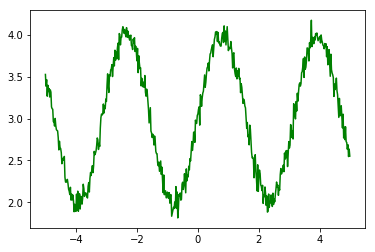

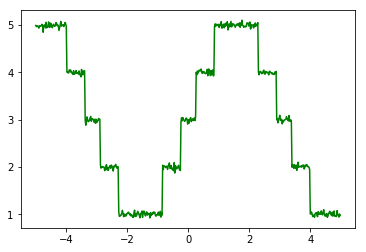

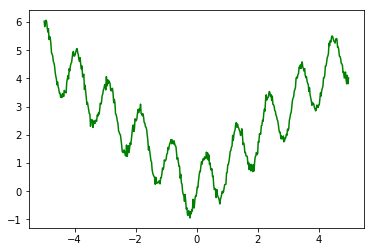

In [15]:
# dataset

def f_sin(x): return sin(2*x) + 3

def f_round(x): return round(2*sin(x) + 3)

def f_absin(x): return sin(6*x) + abs(x)


x = np.arange(-5, 5, 0.02).reshape(-1,1)
y_f1 = np.array([f_sin(x) + np.random.normal(0, 0.08) for x in x]).reshape(-1,1)
y_f2 = np.array([f_round(x) + np.random.normal(0, 0.04) for x in x]).reshape(-1,1)
y_f3 = np.array([f_absin(x) + np.random.normal(0, 0.1) for x in x]).reshape(-1,1)


plt.plot(x,y_f1, 'green')
plt.show()

plt.plot(x,y_f2, 'green')
plt.show()

plt.plot(x,y_f3, 'green')
plt.show()


### Section 1.3: Variables Globales

In [4]:
epochs = 10000
batch_size = 100

x_batch = tf.placeholder(shape=[None, 1], dtype=tf.float64, name='x_batch')
y_batch = tf.placeholder(shape=[None, 1], dtype=tf.float64, name='y_batch')

### Section 1.4: Fit

In [5]:
def Fit(x_train,y_train,model, verbose = 2000):
    sess = tf.Session()
    init_vars = tf.variables_initializer(tf.global_variables())
    sess.run(init_vars)
    for epoch in range(epochs):
        indices = np.random.choice(x_train.shape[0], size=batch_size)
        x_b = x_train[indices]
        y_b = y_train[indices]
        feed_dict = {x_batch: x_b, y_batch: y_b}
        sess.run(model, feed_dict=feed_dict)
        if epoch%verbose ==0:
            print("Loss = ", sess.run(avg_llh, feed_dict=feed_dict))
    return sess

### Section 1.5: Predict

In [6]:
def Predict(x_test,session):
    feed_dict = {x_batch: x_test}
    yh_vals = session.run((y_pred), feed_dict=feed_dict)
    return yh_vals

    

### Section 1.6: MLP

In [7]:
def MLP(x_b,tab_neurones, tab_activation, name="MLP"):
    with tf.name_scope(name):
        outs = []
        for i in range(len(tab_neurones)):
            if i == 0 :
                input_nb_neurone = x_b.shape[1]
                input_data = x_b
            else:
                input_nb_neurone = tab_neurones[i-1]
                input_data = outs[i-1]
            W = tf.Variable(np.random.rand(input_nb_neurone,tab_neurones[i]), dtype=tf.float64, name="W")
            b = tf.Variable(np.random.rand(tab_neurones[i]), dtype=tf.float64, name="b")
            if (tab_activation[i] == "relu"):
                out = tf.nn.relu(tf.matmul(input_data, W) + b)
            elif (tab_activation[i] == "sigmoid"):
                out = tf.nn.sigmoid(tf.matmul(input_data, W) + b)
            elif (tab_activation[i] == "tanh"):
                out = tf.tanh(tf.matmul(input_data, W) + b)
            elif (tab_activation[i] == "softmax"):
                out = tf.nn.softmax(tf.matmul(input_data, W) + b)
            else:
                out = tf.matmul(input_data, W) + b
            outs.append(out)
        return outs
        

### Section 1.7: Test d'un modèle

In [8]:
mlp1 = MLP(x_batch,[8,8,1], ['tanh','tanh','identity'])

# output layer
y_pred = mlp1[-1]

with tf.name_scope("loss"):
    # loss function
    loglikelihoods = tf.square(y_pred - y_batch)
    avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.01)
model = opt.minimize(avg_llh)

In [9]:
# fit the model
modelFit = Fit(x,y_f1,model)

Loss =  17.761277530028448
Loss =  0.21538067571543312
Loss =  0.05506160576783541
Loss =  0.008240914824757039
Loss =  0.0061320969363312305


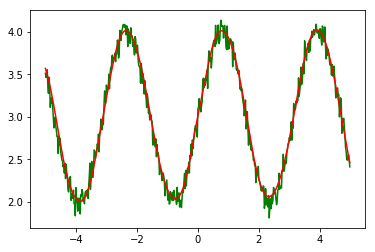

In [10]:
# predict 
modelPredict = Predict(x,modelFit)

plt.plot(x,y_f1, 'green')
plt.plot(x,modelPredict, 'red')
plt.show()

In [11]:
writer = tf.summary.FileWriter("/tmp/graph/1")
writer.add_graph(modelFit.graph)

In [12]:
Image(filename = "/home/adeleruyelle/Images/tsb1.png", width=500, height=500)
modelFit.close()

## Partie 2: Utilisation des différentes fonctions d'activation.

Dans cette partie, nous allons étudier les 4 fonctions d'activation (Relu, sigmoide, tanh, identité).
Pour ce faire, nous avons choisi un optimiseur (Adam) de manière à ne changer que la couche d'activation.

### Section 2.1: fonction de test

In [12]:
# mse

def mse(y_pred,y):
    return np.mean(np.square(y_pred - y))

npArray1 = np.array([1,2,4])
npArray2 = np.array([1,3,7])

print("mse = " + str(mse(npArray1,npArray2)))

# mae

def mae(y_pred,y):
    return np.mean(np.abs(y_pred - y))

print("mae = " + str(mae(npArray1,npArray2)))

mse = 3.3333333333333335
mae = 1.3333333333333333


In [13]:
# test with mean of n launch

def testFunctionActivation(n, x_vals, y_vals, model):
    liste_result = []
    for i in range(n):
        session = Fit(x_vals, y_vals, model, verbose = 5000)
        y_result = Predict(x_vals,session)
        liste_result.append(y_result)
        session.close()
    result = np.mean(liste_result, axis = 0)
    return result.reshape(result.shape[0],1)
        

### Section 2.2: Relu

In [14]:
# model with Relu

mlp_relu = MLP(x_batch,[8,8,8,1], ['relu','relu','relu','identity'])

# output layer
y_pred = mlp_relu[-1]

with tf.name_scope("loss"):
    # loss function
    loglikelihoods = tf.square(y_pred - y_batch)
    avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.01)
modelRelu = opt.minimize(avg_llh)

(?, 1)


In [15]:
# train model
resRelu_sin = testFunctionActivation(5,x,y_f1,modelRelu)
resRelu_round = testFunctionActivation(5,x,y_f2,modelRelu)
resRelu_absin = testFunctionActivation(5,x,y_f3,modelRelu)

Loss =  8311.728301013689
Loss =  0.4052554582370575
Loss =  9713.448548124665
Loss =  0.49901773579715925
Loss =  9892.648139748315
Loss =  0.4555295148476112
Loss =  10132.30796808251
Loss =  0.4432179205949891
Loss =  6961.089489007423
Loss =  0.47511622545193816
Loss =  8361.771955611066
Loss =  0.1299800483547548
Loss =  9175.13969441469
Loss =  0.15174343778705773
Loss =  8898.561671010488
Loss =  0.17985475693606146
Loss =  11077.934791674646
Loss =  0.16880498239008998
Loss =  10943.009853500367
Loss =  0.16969377301686644
Loss =  9884.099812755514
Loss =  0.4878051916030519
Loss =  10871.53636742886
Loss =  0.5556864702319286
Loss =  9942.215512044571
Loss =  0.501384111982108
Loss =  11309.0079864536
Loss =  0.5441643169667231
Loss =  10308.632462460166
Loss =  0.5398696124267527


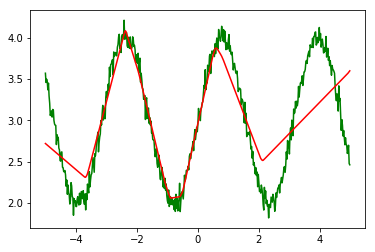

mae = 0.2667280461143014
mse = 0.12876679356630505


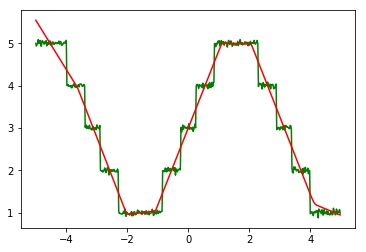

mae = 0.20132923488719887
mse = 0.0667415002750354


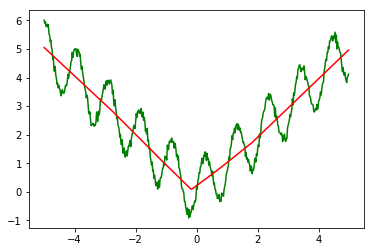

mae = 0.6436288869503415
mse = 0.5133266340712914


In [16]:
# print result

plt.plot(x,y_f1, 'green')
plt.plot(x,resRelu_sin, 'red')
plt.show()

print( "mae = " + str(mae(resRelu_sin,y_f1)))
print( "mse = " + str(mse(resRelu_sin,y_f1)))


plt.plot(x,y_f2, 'green')
plt.plot(x,resRelu_round, 'red')
plt.show()

print( "mae = " + str(mae(resRelu_round,y_f2)))
print( "mse = " + str(mse(resRelu_round,y_f2)))


plt.plot(x,y_f3, 'green')
plt.plot(x,resRelu_absin, 'red')
plt.show()

print( "mae = " + str(mae(resRelu_absin,y_f3)))
print( "mse = " + str(mse(resRelu_absin,y_f3)))

### Section 2.3: Sigmoide

In [17]:
# model with sigmoid

mlp_sigmoid = MLP(x_batch,[8,8,8,1], ['sigmoid','sigmoid','sigmoid','identity'])

# output layer
y_pred = mlp_sigmoid[-1]

#loss function
with tf.name_scope("loss"):
    loglikelihoods = tf.square(y_pred - y_batch)
    avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.01)
modelSigmoid = opt.minimize(avg_llh)

(?, 1)


In [18]:
# train model
resSigmoid_sin = testFunctionActivation(5,x,y_f1,modelSigmoid)
resSigmoid_round = testFunctionActivation(5,x,y_f2,modelSigmoid)
resSigmoid_absin = testFunctionActivation(5,x,y_f3,modelSigmoid)

Loss =  0.8401688325569774
Loss =  0.17446117000501155
Loss =  0.805585992744281
Loss =  0.16109700715095093
Loss =  0.7631923940905014
Loss =  0.2193184289502951
Loss =  0.7809308555334156
Loss =  0.2774114306807984
Loss =  0.8037579815684677
Loss =  0.26734510484820345
Loss =  2.783577451710374
Loss =  0.08057800132979917
Loss =  2.8153435232140236
Loss =  0.07916588130731247
Loss =  2.693520843182422
Loss =  0.07609577829218674
Loss =  2.6073369324744418
Loss =  0.07677631168186844
Loss =  2.2368465092977643
Loss =  0.06576165413371397
Loss =  3.7446507307451338
Loss =  0.4863644614218428
Loss =  4.5331893771055665
Loss =  0.5789811228785341
Loss =  4.192702285419752
Loss =  0.5316657330816658
Loss =  4.985954176730353
Loss =  0.462781478543982
Loss =  3.7846859047788204
Loss =  0.4627781598318093


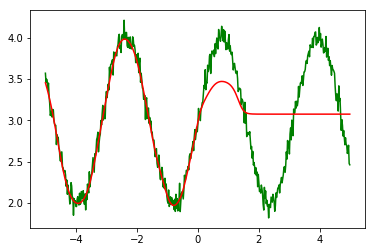

mae = 0.2926551323866234
mse = 0.18863719727463577


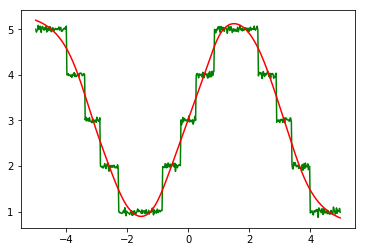

mae = 0.20792243348170422
mse = 0.06592565108002194


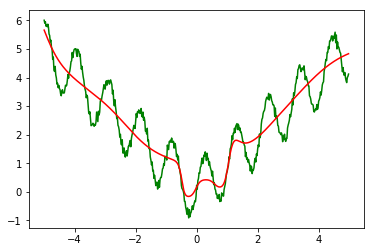

mae = 0.5711929030128062
mse = 0.434364512014358


In [19]:
# print result

plt.plot(x,y_f1, 'green')
plt.plot(x,resSigmoid_sin, 'red')
plt.show()

print( "mae = " + str(mae(resSigmoid_sin,y_f1)))
print( "mse = " + str(mse(resSigmoid_sin,y_f1)))


plt.plot(x,y_f2, 'green')
plt.plot(x,resSigmoid_round, 'red')
plt.show()

print( "mae = " + str(mae(resSigmoid_round,y_f2)))
print( "mse = " + str(mse(resSigmoid_round,y_f2)))


plt.plot(x,y_f3, 'green')
plt.plot(x,resSigmoid_absin, 'red')
plt.show()

print( "mae = " + str(mae(resSigmoid_absin,y_f3)))
print( "mse = " + str(mse(resSigmoid_absin,y_f3)))

### Section 2.4: Tanh

In [20]:
# model with tanh

mlp_tanh = MLP(x_batch,[8,8,8,1], ['tanh','tanh','tanh','identity'])

# output layer
y_pred = mlp_tanh[-1]


# loss function
with tf.name_scope("loss"):
    loglikelihoods = tf.square(y_pred - y_batch)
    avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.01)
modelTanh = opt.minimize(avg_llh)

(?, 1)


In [21]:
# train model
resTanh_sin = testFunctionActivation(5,x,y_f1,modelTanh)
resTanh_round = testFunctionActivation(5,x,y_f2,modelTanh)
resTanh_absin = testFunctionActivation(5,x,y_f3,modelTanh)

Loss =  14.753040636815136
Loss =  0.19639276464006541
Loss =  15.175153201940248
Loss =  0.21106711396500594
Loss =  12.009884023498484
Loss =  0.04002526521897896
Loss =  13.174493732516675
Loss =  0.18238994688759738
Loss =  12.380928772703996
Loss =  0.2534892908203659
Loss =  13.411099426905855
Loss =  0.0539167510507318
Loss =  16.985416401992087
Loss =  0.04453982651695473
Loss =  14.825741524102863
Loss =  0.05558291710497029
Loss =  12.554928184222959
Loss =  0.05643759421210335
Loss =  14.955784520664972
Loss =  0.04755963667329823
Loss =  15.857634163575675
Loss =  0.08071529078246709
Loss =  18.53235088253465
Loss =  0.22474912736286076
Loss =  12.134863912186113
Loss =  0.2083836517285243
Loss =  16.890373879498306
Loss =  0.1727682108013284
Loss =  13.425324810542566
Loss =  0.2387291161623552


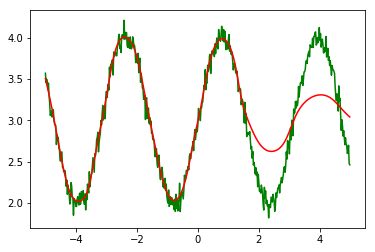

mae = 0.18047721265431732
mse = 0.07464245578951055


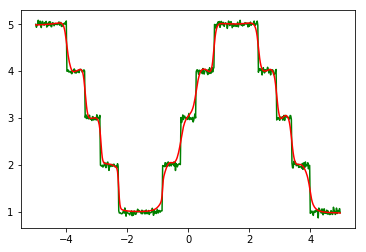

mae = 0.09198837032332267
mse = 0.022059857885564166


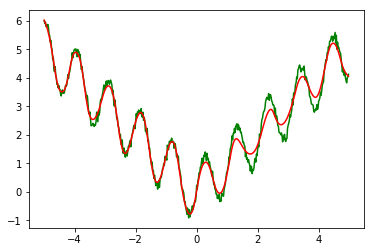

mae = 0.17710881078209315
mse = 0.05409214789703239


In [22]:
# print result

plt.plot(x,y_f1, 'green')
plt.plot(x,resTanh_sin, 'red')
plt.show()

print( "mae = " + str(mae(resTanh_sin,y_f1)))
print( "mse = " + str(mse(resTanh_sin,y_f1)))


plt.plot(x,y_f2, 'green')
plt.plot(x,resTanh_round, 'red')
plt.show()

print( "mae = " + str(mae(resTanh_round,y_f2)))
print( "mse = " + str(mse(resTanh_round,y_f2)))


plt.plot(x,y_f3, 'green')
plt.plot(x,resTanh_absin, 'red')
plt.show()

print( "mae = " + str(mae(resTanh_absin,y_f3)))
print( "mse = " + str(mse(resTanh_absin,y_f3)))

### Section 2.4: Identité

In [23]:
# model without activation

mlp_id = MLP(x_batch,[8,8,8,1], ['identity','identity','identity','identity'])

# output layer
y_pred = mlp_id[-1]


# loss function
with tf.name_scope("loss"):
    loglikelihoods = tf.square(y_pred - y_batch)
    avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.01)
modelId = opt.minimize(avg_llh)

(?, 1)


In [24]:
# train model
resId_sin = testFunctionActivation(5,x,y_f1,modelId)
resId_round = testFunctionActivation(5,x,y_f2,modelId)
resId_absin = testFunctionActivation(5,x,y_f3,modelId)

Loss =  10995.562409726339
Loss =  0.4817834629324278
Loss =  7434.800844082517
Loss =  0.5009075982290089
Loss =  10729.264030338662
Loss =  0.4319836802297769
Loss =  8760.060648894367
Loss =  0.517236684827912
Loss =  7274.856723918775
Loss =  0.5025194470617061
Loss =  9484.887519047736
Loss =  2.5777627072703235
Loss =  9955.130950472994
Loss =  1.8368422662837742
Loss =  9683.07646530631
Loss =  2.1488718398317745
Loss =  10981.578548705507
Loss =  2.2890492420500648
Loss =  10011.766935183148
Loss =  2.2196981046414446
Loss =  10064.732573037403
Loss =  2.583372854560173
Loss =  9091.6944298877
Loss =  3.277041365554966
Loss =  9375.770452022096
Loss =  2.319276074816279
Loss =  10497.352943770504
Loss =  2.7942951555743036
Loss =  10389.048844045545
Loss =  2.844502597387592


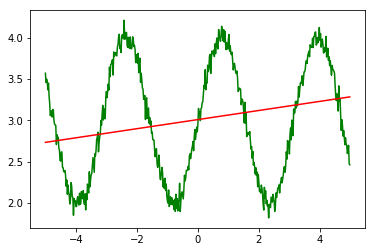

mae = 0.6010602894863878
mse = 0.4670065452453566


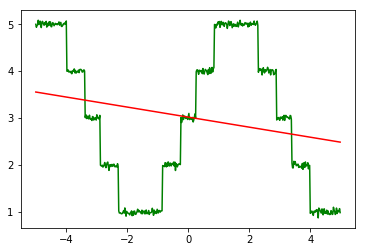

mae = 1.3217971606360621
mse = 2.214774272133602


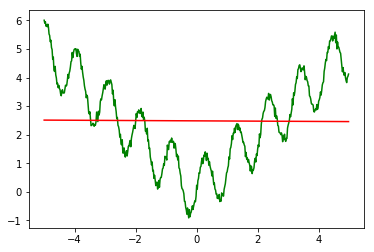

mae = 1.3547886864603367
mse = 2.61721614271902


In [25]:
# print result

plt.plot(x,y_f1, 'green')
plt.plot(x,resId_sin, 'red')
plt.show()

print( "mae = " + str(mae(resId_sin,y_f1)))
print( "mse = " + str(mse(resId_sin,y_f1)))


plt.plot(x,y_f2, 'green')
plt.plot(x,resId_round, 'red')
plt.show()

print( "mae = " + str(mae(resId_round,y_f2)))
print( "mse = " + str(mse(resId_round,y_f2)))


plt.plot(x,y_f3, 'green')
plt.plot(x,resId_absin, 'red')
plt.show()

print( "mae = " + str(mae(resId_absin,y_f3)))
print( "mse = " + str(mse(resId_absin,y_f3)))

## Part 3: Généralisation

Dans cette partie, nous allons ajouter des indicateurs concernant la généralisation de nos algorithmes.

### Section 3.1: train/test

In [26]:
def train_test(x,y,ratio):
    union = np.hstack((x,y))
    np.random.shuffle(union)
    split = np.hsplit(union,2)
    ratio_separate = int(ratio * len(x))
    return (split[0][:ratio_separate],split[0][ratio_separate:],split[1][:ratio_separate],split[1][ratio_separate:])
    
    

In [27]:
x_train_f1,x_test_f1,y_train_f1,y_test_f1 = train_test(x,y_f1,0.8)
x_train_f2,x_test_f2,y_train_f2,y_test_f2 = train_test(x,y_f2,0.8)
x_train_f3,x_test_f3,y_train_f3,y_test_f3 = train_test(x,y_f3,0.8)

### Section 3.2: Fit with train/test

In [21]:
def Fit(x_train,x_test,y_train,y_test,model, verbose = 500):
    sess = tf.Session()
    init_vars = tf.variables_initializer(tf.global_variables())
    sess.run(init_vars)
    visualisation = []
    for epoch in range(epochs):
        indices = np.random.choice(x_train.shape[0], size=batch_size)
        x_b = x_train[indices]
        y_b = y_train[indices]
        feed_dict = {x_batch: x_b, y_batch: y_b}
        sess.run(model, feed_dict=feed_dict)
        if epoch%verbose ==0:
            feed_dict_train = {x_batch: x_train, y_batch: y_train}
            feed_dict_test = {x_batch: x_test, y_batch: y_test}
            loss_train = sess.run(avg_llh, feed_dict=feed_dict_train)
            loss_test = sess.run(avg_llh, feed_dict=feed_dict_test)
            print("Epoch: ", epoch)
            print("Loss train = ", loss_train)
            print("Loss test = ", loss_test)
            visualisation.append(np.array([epoch,loss_train,loss_test]))
    return (sess,np.array(visualisation))

In [29]:
mlp1 = MLP(x_batch,[8,8,1], ['relu','relu','identity'])

# output layer
y_pred = mlp1[-1]

# loss function
with tf.name_scope("loss"):
    loglikelihoods = tf.square(y_pred - y_batch)
    avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.01)
model = opt.minimize(avg_llh)

(?, 1)


In [30]:
# fit the model
modelFit,visu = Fit(x_train_f1,x_test_f1,y_train_f1,y_test_f1,model)

Epoch:  0
Loss train =  818.373412913387
Loss test =  983.7107403197822
Epoch:  500
Loss train =  0.5885298703072626
Loss test =  0.585361787125197
Epoch:  1000
Loss train =  0.47674479108501716
Loss test =  0.4807084886502126
Epoch:  1500
Loss train =  0.46273825902440024
Loss test =  0.4685962425750935
Epoch:  2000
Loss train =  0.4525516189578657
Loss test =  0.46464003885960536
Epoch:  2500
Loss train =  0.4413746551742013
Loss test =  0.452742031823675
Epoch:  3000
Loss train =  0.4316705769655431
Loss test =  0.44871000945341327
Epoch:  3500
Loss train =  0.4186102189051089
Loss test =  0.441008836988552
Epoch:  4000
Loss train =  0.39892475420699514
Loss test =  0.42666248951901975
Epoch:  4500
Loss train =  0.3721297255061977
Loss test =  0.4124297589451074
Epoch:  5000
Loss train =  0.3367853908921831
Loss test =  0.3863796905059171
Epoch:  5500
Loss train =  0.31249592454329345
Loss test =  0.37842005345238716
Epoch:  6000
Loss train =  0.3098375883477963
Loss test =  0.38510

In [93]:
def print_visu(visu):
    error = np.hsplit(visu,3)
    plt.plot(error[0],error[1], 'green', label='train')
    plt.plot(error[0],error[2], 'red',label='test')
    plt.legend()
    plt.show()

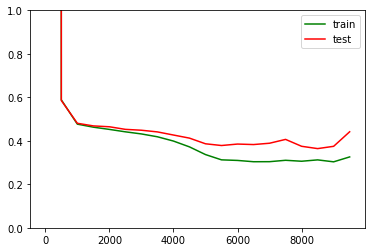

In [32]:
plt.axis(ymax=1,y_min = 0)
print_visu(visu)

La courbe de test est plus basse .....

Il faut tester sur des données plus complexes. Nous allons voir avec les données MNIST

## Part 4: MNIST

### Section 4.1: Récupération des données

In [13]:
mnist = tf.keras.datasets.mnist

In [14]:
# download data
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [15]:
def mnist_label(i):
    label = np.zeros(10)
    label[i] = 1
    return label

In [16]:
y_train_mnist = np.array([mnist_label(y_train[i]) for i in range(len(y_train))])
y_test_mnist = np.array([mnist_label(y_test[i]) for i in range(len(y_test))])

In [17]:
#reformat data
x_train = x_train.reshape(60000,784).astype(float)
y_train = y_train_mnist.reshape(60000,10).astype(float)
x_test = x_test.reshape(10000,784).astype(float)
y_test = y_test_mnist.reshape(10000,10).astype(float)

### Section 4.2: Création d'un MLP pour la classif

In [18]:
epochs = 2400
batch_size = 1000

x_batch = tf.placeholder(shape=[None, 784], dtype=tf.float64, name='x_batch')
y_batch = tf.placeholder(shape=[None, 10], dtype=tf.float64, name='y_batch')

In [32]:
mlp_mnist = MLP(x_batch,[25,10], ['sigmoid','identity'])

# output layer
y_pred = mlp_mnist[-1]

# loss function
loglikelihoods = tf.nn.softmax_cross_entropy_with_logits_v2(logits = y_pred, labels = y_batch)
avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.001)
model_mnist = opt.minimize(avg_llh)

In [33]:
# fit the model
modelFit_mnist,visu = Fit(x_train,x_test,y_train,y_test,model_mnist)

Epoch:  0
Loss train =  3.6532399592133507
Loss test =  3.6608209747983653
Epoch:  500
Loss train =  2.3013842547340913
Loss test =  2.301494470320866
Epoch:  1000
Loss train =  2.3014858837655368
Loss test =  2.3013680011995863
Epoch:  1500
Loss train =  2.301756451249754
Loss test =  2.301401330820719
Epoch:  2000
Loss train =  2.301364660485767
Loss test =  2.3012497580863114


In [23]:
writer = tf.summary.FileWriter("/tmp/graph/2")
writer.add_graph(modelFit_mnist.graph)

In [24]:
result_mnist = Predict(x_test,modelFit_mnist)

In [25]:
correct_prediction = np.equal(np.argmax(result_mnist, 1), np.argmax(y_test, 1))
accuracy = np.mean(correct_prediction.astype(float))

print(accuracy)

0.1135


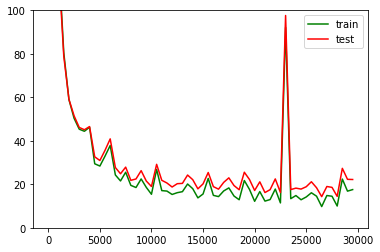

In [96]:
plt.axis(ymax=100,y_min = 0)
print_visu(visu)

### Section 5: Early Stopping

In [80]:
def ES(x_train,x_test,y_train,y_test,model,n = 500, p = 15, verbose = 500):
    sess = tf.Session()
    init_vars = tf.variables_initializer(tf.global_variables())
    sess.run(init_vars)
    saver = tf.train.Saver()
    visualisation = []
    j = 0
    step = 0
    best_loss = np.inf
    while j < p:
        # train n steps
        for i in range(n):
            indices = np.random.choice(x_train.shape[0], size=batch_size)
            x_b = x_train[indices]
            y_b = y_train[indices]
            feed_dict = {x_batch: x_b, y_batch: y_b}
            sess.run(model, feed_dict=feed_dict)
            step = step+1
        # compute en print actual score
        feed_dict_train = {x_batch: x_train, y_batch: y_train}
        feed_dict_test = {x_batch: x_test, y_batch: y_test}
        loss_train = sess.run(avg_llh, feed_dict=feed_dict_train)
        loss_test = sess.run(avg_llh, feed_dict=feed_dict_test)
        print("Loss train = ", loss_train)
        print("Loss test = ", loss_test)
        visualisation.append(np.array([step,loss_train,loss_test]))
        #compare loss
        if loss_test < best_loss:
            save_path = saver.save(sess, "/tmp/best_model.ckpt")
            j = 0
            best_loss = loss_test
        else:
            j = j+1
    best_model = saver.restore(sess, "/tmp/best_model.ckpt")
    return (sess,np.array(visualisation))

In [98]:
mlp_mnist = MLP(x_batch,[16,16,16,16,10], ['identity','identity','identity','identity','identity'])

# output layer
y_pred = mlp_mnist[-1]

# loss function
loglikelihoods = tf.nn.softmax_cross_entropy_with_logits_v2(logits = y_pred, labels = y_batch)
avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.001)
model_mnist = opt.minimize(avg_llh)

(?, 784)


In [99]:
# fit the model
ES_fit_mnist,visu = ES(x_train,x_test,y_train,y_test,model_mnist)

Loss train =  20087.657130301308
Loss test =  20178.028294384785
Loss train =  26426.419549389295
Loss test =  26703.995668187956
Loss train =  34945.585500979156
Loss test =  35737.4081735736
Loss train =  17698.219821337152
Loss test =  18030.91526804819
Loss train =  16061.04532200875
Loss test =  16233.54050295791
Loss train =  11361.989332677942
Loss test =  11559.201051689099
Loss train =  2826.1175139136417
Loss test =  2890.829815258434
Loss train =  1194.0516888622183
Loss test =  1190.1740310085786
Loss train =  447.10142551506976
Loss test =  447.0201990344634
Loss train =  280.0496587668554
Loss test =  278.8653441794706
Loss train =  289.06302764229315
Loss test =  288.4465075003673
Loss train =  1429.422892393617
Loss test =  1470.183725961865
Loss train =  198.98533329532478
Loss test =  197.55818663612337
Loss train =  1727.8853474160192
Loss test =  1789.4242315801591
Loss train =  162.3063190453894
Loss test =  158.94315238944776
Loss train =  156.3982010322611
Loss t

Loss train =  0.2690437591598054
Loss test =  0.33725499093886413
Loss train =  0.26536313798995737
Loss test =  0.33796769557664846
Loss train =  0.26616988736597913
Loss test =  0.34496188546604817
Loss train =  0.27034646361469905
Loss test =  0.355070938254627
Loss train =  0.2684978699905095
Loss test =  0.35149254763850046
Loss train =  0.2759428125868078
Loss test =  0.34164405763901634
Loss train =  0.2714119192161616
Loss test =  0.3521216792367807
Loss train =  0.28092870252240587
Loss test =  0.35964558748791553
Loss train =  0.28800824039273637
Loss test =  0.3599516106443727
Loss train =  0.26411537410210867
Loss test =  0.33696690363079645
Loss train =  2.5869663681725044
Loss test =  2.9264316588382835
Loss train =  0.32976257483499744
Loss test =  0.45740860093623703
Loss train =  0.25403781649793034
Loss test =  0.3365723702975718
Loss train =  0.2500387643461882
Loss test =  0.32551370373512367
Loss train =  0.2542418662601085
Loss test =  0.3301215978595488
Loss trai

In [100]:
result_mnist = Predict(x_test,ES_fit_mnist)

In [101]:
correct_prediction = np.equal(np.argmax(result_mnist, 1), np.argmax(y_test, 1))
accuracy = np.mean(correct_prediction.astype(float))

print(accuracy)

0.9195


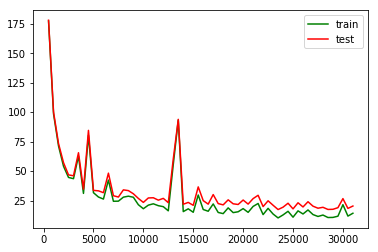

In [85]:
# visualize error
error = np.hsplit(visu,3)
plt.plot(error[0],error[1], 'green', label='train')
plt.plot(error[0],error[2], 'red',label='test')
#plt.axis(ymax=1,ymin = 0)
plt.legend()
plt.show()

## Part 6: Fit en live

In [182]:
%matplotlib notebook

def update_line(ax,fig,x_train,y_train,x_test, y_pred):
    plt.pause(0.05)
    ax.clear()
    m = max(y_train)
    mm = min(y_train)
    
    plt.axis(ymax=m*1.1,y_min = mm - 1)
    ax.plot(x_train, y_train, color = 'blue')
    ax.plot(x_test, y_pred, color = 'red')
    fig.canvas.draw()


def ES_dynamic_print(x_train,x_test,y_train,y_test,model,n = 250, p = 20, verbose = 500):
    plt.ion()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig.show()
    fig.canvas.draw()
    plt.plot(x_train, y_train)
    sess = tf.Session()
    init_vars = tf.variables_initializer(tf.global_variables())
    sess.run(init_vars)
    saver = tf.train.Saver()
    visualisation = []
    j = 0
    step = 0
    best_loss = np.inf
    while j < p:
        # train n steps
        for i in range(n):
            indices = np.random.choice(x_train.shape[0], size=batch_size)
            x_b = x_train[indices]
            y_b = y_train[indices]
            feed_dict = {x_batch: x_b, y_batch: y_b}
            sess.run(model, feed_dict=feed_dict)
            step = step+1
        # compute en print actual score
        feed_dict_train = {x_batch: x_train, y_batch: y_train}
        feed_dict_test = {x_batch: x_test, y_batch: y_test}
        loss_train = sess.run(avg_llh, feed_dict=feed_dict_train)
        loss_test = sess.run(avg_llh, feed_dict=feed_dict_test)
        pred = sess.run(y_pred, feed_dict=feed_dict_test)
        # affichage plot
        update_line(ax,fig,x_train,y_train,x_test,pred)
        visualisation.append(np.array([step,loss_train,loss_test]))
        #compare loss
        if loss_test < best_loss:
            save_path = saver.save(sess, "/tmp/best_model.ckpt")
            j = 0
            best_loss = loss_test
        else:
            j = j+1
    best_model = saver.restore(sess, "/tmp/best_model.ckpt")
    return (sess,np.array(visualisation))

In [183]:
mlp1 = MLP(x_batch,[32,32,1], ['relu','relu','identity'])

# output layer
y_pred = mlp1[-1]

with tf.name_scope("loss"):
    # loss function
    loglikelihoods = tf.square(y_pred - y_batch)
    avg_llh = tf.reduce_mean(loglikelihoods)

# optimizer
opt = tf.train.AdamOptimizer(learning_rate=0.001)
model = opt.minimize(avg_llh)

<IPython.core.display.Javascript object>


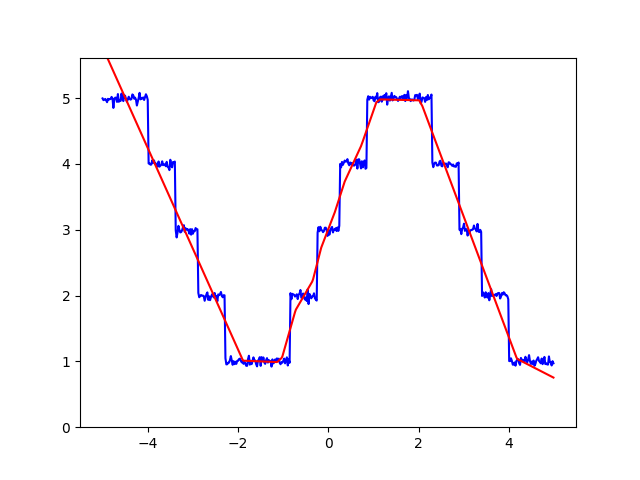

INFO:tensorflow:Restoring parameters from /tmp/best_model.ckpt


In [184]:
ESfit = ES_dynamic_print(x,x,y_f2,y_f2,model)